# Portfolio Optimization

In [1]:
from pyfinlab import data_api as api
from pyfinlab import risk_models as risk
from pyfinlab import return_models as ret
from pyfinlab import portfolio_optimization as opt
from pyfinlab import performance as perf
from pyfinlab import report_generation as report
from pyfinlab import backtesting as bkt
%matplotlib inline

## Introduction

Navigate to the data folder and open the 'portopt_inputs.xlsx' Excel file. The 'mapping' tab contains columns for the tickers, their names, multiple categories by which to classify each ticker, and ending with a MIN and MAX column where you set your ticker-level weighting constraints. The 'mapping' tab is used to map each category to each ticker allowing you to easily constrain both at the ticker-level and category-level. The other tabs contain the constraints for each of the categories contained in the 'mapping' tab as columns. They are region, size, style, credit, duration, asset_class, sec_type, holding, and sector. 

##### Category Definitions

* 'SIZE': Market cap size of common stocks and underlying holdings in equity ETFs.
    * example: large cap, mid cap, small cap
* 'SECTOR': Equity sector of common stocks and underlying holdings in equity ETFs.
    * example: technology, consumer staples, healthcare
* 'STYLE': Investment style of common stocks and underlying holdings in equity ETFs.
    * example: value, blend, growth
* 'REGION': Geographic region of all portfolio holdings.
    * example: U.S., Developed Markets, Emerging Markets
* 'HOLDING': Core versus satellite specification for common stocks and underlying holdings in equity ETFs.
    * example: core, satellite...helpful when managing a core/satellite strategy
* 'ASSET_CLASS': Asset class of all portfolio holdings.
    * example: equity, bond
* 'SECURITY_TYPE': Security type of all portfolio holdings.
    * example: common stocks, ETFs
* 'DURATION': Duration for bond ETF underlying holdings.
    * example: long, intermediate, short
* 'CREDIT': Credit quality of bond ETF underlying holdings.
    * example: high, mid, low

Choose an API source, either 'yfinance' which is free, or, 'bloomberg' which requires a Bloomberg Professional Service subscription. 

In [2]:
api_source = 'yfinance' # yfinance or bloomberg

Enter a title used to name the report file. 

In [3]:
title = 'github' # used to name file

Choose a risk model. Here are your choices. 

In [4]:
risk_models = [
    'sample_cov',
    'semicovariance',
    'exp_cov',
    'ledoit_wolf_constant_variance',
    'ledoit_wolf_single_factor',
    'ledoit_wolf_constant_correlation',
    'oracle_approximating'
]

In [5]:
risk_model = 'oracle_approximating' 

Choose a return model. Here are your choices. 

In [6]:
return_models = [
    'simple_return',
    'avg_historical_return',
    'exponential_historical_return'
]

In [7]:
return_model = 'ema_historical_return'

Enter the ticker symbol for your benchmark index.

In [8]:
benchmark_ticker = 'SPY'

How many years of price data do you want to use to optimize portfolios? The length of the price data will be equal to the number of days since inception of the youngest security in your ticker list up to the number you specify in num_years. 

In [9]:
num_years = 10

Gamma is an L2 regularisation, to increase the number of nonzero weights. Increasing this parameter forces the algorithm to increase the number of positions in each portfolio, thus, increasing diversification. Leave gamma at 0.0 if you do not want to use L2 regularisation. Typically, gamma can be anything and you might need to use trial and error to find the right gamma level. If using gamma, I recommend first trying anything from 0.01 to 1.0, and see what portfolios are created. Change gamma as needed. Please see https://pyportfolioopt.readthedocs.io/en/latest/_modules/pypfopt/objective_functions.html#L2_reg for more information. 

In [10]:
gamma = 0.0 # Higher gamma increases portfolio diversification. 

You can also filter out tickers by using a restricted securities list found on the "restricted" tab in the Excel spreadsheet(../data/portopt_inputs.xlsx). 

In [11]:
restricted = True

Assign ticker list using the following steps. 

1) Type the tickers into column A of the "../data/portopt_inputs.xlsx" Excel spreadsheet. 
2) Drag the formulas so that they exactly match up with the tickers you typed into column A. 
3) Check if there are any blank rows after your tickers and delete if found.  

Your ticker column and the data columns should line up EXACTLY. There should also be no blank rows below your tickers. The other columns should populate with data from the "database" and "constraints" tabs using VLOOKUP functions. You need to make sure all your tickers have data.

In [12]:
tickers = opt.tickers

Add custom constraints. These can be found in (../src/pyfinlab/portfolio_optimization.py) starting at line 353. 

In [13]:
add_custom_constraints = False

Choose start and end dates. 

In [14]:
start_date, end_date = api.start_end_dates(num_years, api_source)
print('Start Date: {}'.format(start_date))
print('End Date: {}'.format(end_date))

Start Date: 2011-11-17
End Date: 2021-11-14


Download price data and risk-free rate. 

In [15]:
prices = api.price_history(tickers, start_date, end_date, api_source, restricted=restricted)
risk_free_rate = api.risk_free_rate(prices.index[0], prices.index[-1], api_source)

[*********************100%***********************]  127 of 127 completed
[*********************100%***********************]  1 of 1 completed


Compute covariance matrix and expected return vector. 

In [16]:
cov_matrix = risk.risk_model(prices, risk_model)
exp_returns = ret.return_model(prices, return_model, risk_free_rate)

The following cell contains a pre-processing function which compiles constraints into the required format for the portfolio optimization algorithm. This function is commented out but can be uncommented and run to show the constraints that are being used for debugging purposes. Constraints can be input in the Excel file found at (../data/portopt_inputs.xlsx). 

In [17]:
# (
#     bounds,
#     region_lower, region_upper, region_mapper, size_lower, size_upper, size_mapper,
#     style_lower, style_upper, style_mapper, credit_lower, credit_upper, credit_mapper,
#     duration_lower, duration_upper, duration_mapper, asset_lower, asset_upper, asset_mapper,
#     type_lower, type_upper, type_mapper, holding_lower, holding_upper, holding_mapper,
#     sector_lower, sector_upper, sector_mapper, value, growth, blend, broadmkt, largecap, midcap, smallcap
# ) = opt.constraints(cov_matrix, restricted=False)
# (
#     bounds,
#     region_lower, region_upper, region_mapper, size_lower, size_upper, size_mapper,
#     style_lower, style_upper, style_mapper, credit_lower, credit_upper, credit_mapper,
#     duration_lower, duration_upper, duration_mapper, asset_lower, asset_upper, asset_mapper,
#     type_lower, type_upper, type_mapper, holding_lower, holding_upper, holding_mapper,
#     sector_lower, sector_upper, sector_mapper, value, growth, blend, broadmkt, largecap, midcap, smallcap
# )

## Optimize a single portfolio given 12% target portfolio risk and display. 

Compute optimal portfolio.

In [18]:
target_volatility = 0.12 # choose target volatility and run
objective_function = 'efficient_risk'
optimized_portfolio, optimized_performance = opt.optimize_portfolio(
    exp_returns, cov_matrix,
    risk_model, return_model,
    objective_function,
    target_volatility, 
    restricted=restricted, 
    gamma=gamma, 
    add_custom_constraints=add_custom_constraints
)
opt.display_portfolio(optimized_portfolio, optimized_performance)

                       PORTFOLIO
ema_historical_return     0.3856
oracle_approximating      0.1200
sharpe_ratio              3.0470


,NAME,REGION,HOLDING,SIZE,STYLE,SECTOR,SECURITY_TYPE,ASSET_CLASS,DURATION,CREDIT,WEIGHTING
TICKER,,,,,,,,,,,
BSV,Vanguard Short-Term Bond ETF,U.S.,Core,,,,ETP,Fixed Income,Short-Term,Investment Grade,0.2000
QQQ,Invesco QQQ Trust Series 1,U.S.,Core,Large-cap,Growth,Multi-Sector,ETP,Equity,,,0.1783
TIP,iShares TIPS Bond ETF,U.S.,Core,,,,ETP,Fixed Income,,Investment Grade,0.1250
VGT,Vanguard Information Technology ETF,U.S.,Core,Large-cap,Growth,Technology,ETP,Equity,,,0.0909
GLD,SPDR Gold Shares,Global,Core,,,,ETP,Commodity,,,0.0500
NEAR,BlackRock Short Maturity Bond ETF,U.S.,Satellite,,,,ETP,Fixed Income,Short-Term,,0.0495
ICSH,BlackRock Ultra Short-Term Bon,U.S.,Satellite,,,,ETP,Fixed Income,Short-Term,Investment Grade,0.0480
PANW,Palo Alto Networks Inc,U.S.,Satellite,Large-cap,Growth,Technology,Common Stock,Equity,,,0.0400
PLD,Prologis Inc,U.S.,Core,,,Real Estate,REIT,REIT,,,0.0396


Available categories for grouping cash and risk allocations. 

In [19]:
groups = list(opt.classification.columns[1:])
print('Available Groups: {}'.format(groups))

Available Groups: ['REGION', 'HOLDING', 'SIZE', 'STYLE', 'SECTOR', 'SECURITY_TYPE', 'ASSET_CLASS', 'DURATION', 'CREDIT']


Print cash and risk allocation by weighting. 

In [20]:
group = 'ASSET_CLASS' # Select a category to view portfolio exposure. 
cash_focus = opt.cash_focus(optimized_portfolio).get(group).rename(columns={'WEIGHTING': 'CASH_WTG'})
risk_focus = opt.risk_focus(optimized_portfolio, cov_matrix).get(group).rename(columns={'WEIGHTING': 'RISK_WTG'})
cash_focus = cash_focus.loc[cash_focus.index!=''].sort_values(by='CASH_WTG', ascending=False)
risk_focus = risk_focus.loc[risk_focus.index!=''].sort_values(by='RISK_WTG',ascending=False)
print(cash_focus)
print(' ')
print(risk_focus)

              CASH_WTG
Equity          0.4692
Fixed Income    0.4387
Commodity       0.0500
REIT            0.0396
 
              RISK_WTG
Equity          0.9190
REIT            0.0579
Fixed Income    0.0127
Commodity       0.0105


In [21]:
group = 'SIZE' # Select a category to view portfolio exposure. 
cash_focus = opt.cash_focus(optimized_portfolio).get(group).rename(columns={'WEIGHTING': 'CASH_WTG'})
risk_focus = opt.risk_focus(optimized_portfolio, cov_matrix).get(group).rename(columns={'WEIGHTING': 'RISK_WTG'})
cash_focus = cash_focus.loc[cash_focus.index!=''].sort_values(by='CASH_WTG', ascending=False)
risk_focus = risk_focus.loc[risk_focus.index!=''].sort_values(by='RISK_WTG',ascending=False)
print(cash_focus)
print(' ')
print(risk_focus)

              CASH_WTG
Large-cap       0.3999
Mid-cap         0.0393
Small-cap       0.0300
Broad Market    0.0000
 
              RISK_WTG
Large-cap       0.7099
Mid-cap         0.1139
Small-cap       0.0952
Broad Market    0.0000


In [22]:
group = 'HOLDING' # Select a category to view portfolio exposure. 
cash_focus = opt.cash_focus(optimized_portfolio).get(group).rename(columns={'WEIGHTING': 'CASH_WTG'})
risk_focus = opt.risk_focus(optimized_portfolio, cov_matrix).get(group).rename(columns={'WEIGHTING': 'RISK_WTG'})
cash_focus = cash_focus.loc[cash_focus.index!=''].sort_values(by='CASH_WTG', ascending=False)
risk_focus = risk_focus.loc[risk_focus.index!=''].sort_values(by='RISK_WTG',ascending=False)
print(cash_focus)
print(' ')
print(risk_focus)

           CASH_WTG
Core         0.7000
Satellite    0.2975
 
           RISK_WTG
Core         0.5510
Satellite    0.4491


## Compute Efficient Frontier Portfolios

In [23]:
optimized_portfolios, results = opt.compute_efficient_frontier(
    exp_returns, cov_matrix, risk_model, return_model, restricted, gamma, add_custom_constraints
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:48<00:00,  2.45s/it]


Show efficient frontier portfolios cash weightings. 

In [24]:
optimized_portfolios.iloc[:, 10:].loc[~(optimized_portfolios.iloc[:, 10:]==0).all(axis=1)]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
TICKER,,,,,,,,,,,,,,,,,,,,
AGG,0.0000,0.0000,0.0000,0.0096,0.0388,0.0400,0.0248,0.0369,0.0454,0.0291,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
AIG,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0200
AON,0.0000,0.0055,0.0167,0.0224,0.0358,0.0340,0.0367,0.0391,0.0398,0.0396,0.0408,0.0445,0.0469,0.0492,0.0500,0.0500,0.0500,0.0500,0.0500,0.0100
AR,0.0000,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100
BNDX,0.2000,0.2000,0.2000,0.2000,0.2000,0.2000,0.1542,0.0908,0.0320,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
BSV,0.2000,0.2000,0.2000,0.2000,0.2000,0.2000,0.2000,0.2000,0.2000,0.2000,0.2000,0.2000,0.1746,0.1216,0.0695,0.0172,0.0000,0.0000,0.0000,0.0000
CLR,0.0000,0.0000,0.0000,0.0000,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100
DVAX,0.0000,0.0084,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100
EMTL,0.0435,0.0312,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Show tickers that were removed due to being on the restricted securities list. 

In [25]:
optimized_portfolios.index.difference(cov_matrix.index)

Index([], dtype='object', name='TICKER')

Compute risk weightings. 

In [26]:
optimized_portfolios = optimized_portfolios[optimized_portfolios.index.isin(cov_matrix.index)]
risk_weightings = opt.risk_weightings(optimized_portfolios, cov_matrix)

Show the risk and return model inputs for the optimizer for each efficient frontier portfolio and the expected sharpe ratio. 

In [27]:
results

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
efficient_frontier,,,,,,,,,,,,,,,,,,,,
ema_historical_return,0.0441,0.1385,0.1910,0.2290,0.2625,0.2905,0.3146,0.3373,0.3590,0.3801,0.4009,0.4211,0.4410,0.4609,0.4805,0.5001,0.5174,0.5329,0.5483,0.5598
oracle_approximating,0.0233,0.0337,0.0442,0.0546,0.0650,0.0755,0.0859,0.0964,0.1068,0.1172,0.1277,0.1381,0.1485,0.1590,0.1694,0.1799,0.1903,0.2007,0.2112,0.2216
sharpe_ratio,1.0360,3.5159,3.8694,3.8287,3.7303,3.5832,3.4293,3.2915,3.1738,3.0721,2.9825,2.9045,2.8353,2.7732,2.7184,2.6687,2.6136,2.5555,2.5014,2.4361


Show the cash and risk weightings grouped by asset class. 

In [28]:
print('Available Groups: {}'.format(groups))

Available Groups: ['REGION', 'HOLDING', 'SIZE', 'STYLE', 'SECTOR', 'SECURITY_TYPE', 'ASSET_CLASS', 'DURATION', 'CREDIT']


In [29]:
group = 'ASSET_CLASS'
opt.cash_focus(optimized_portfolios).get(group)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Commodity,0.0000,0.0000,0.0000,0.0230,0.0480,0.0500,0.0500,0.0500,0.0500,0.0500,0.0500,0.0500,0.0500,0.0500,0.0500,0.0500,0.0130,0.0000,0.0000,0.0000
Equity,0.0115,0.0508,0.1091,0.1491,0.1902,0.2454,0.3064,0.3577,0.4048,0.4565,0.5053,0.5547,0.6083,0.6614,0.7134,0.7657,0.8198,0.8726,0.9246,0.9579
Fixed Income,0.9747,0.9312,0.8737,0.8005,0.7219,0.6650,0.6040,0.5502,0.4999,0.4516,0.4025,0.3532,0.2996,0.2466,0.1945,0.1422,0.1250,0.0854,0.0333,0.0000
REIT,0.0000,0.0000,0.0108,0.0266,0.0396,0.0396,0.0396,0.0396,0.0396,0.0396,0.0396,0.0396,0.0396,0.0396,0.0396,0.0396,0.0396,0.0396,0.0396,0.0396


In [30]:
opt.risk_focus(optimized_portfolios, cov_matrix).get(group)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Commodity,0.0000,0.0000,0.0000,0.0165,0.0300,0.0238,0.0189,0.0156,0.0132,0.0110,0.0094,0.0083,0.0074,0.0066,0.0059,0.0054,0.0010,0.0000,0.0000,0.0000
Equity,0.0055,0.5054,0.7144,0.7543,0.7639,0.8190,0.8576,0.8817,0.8994,0.9154,0.9267,0.9348,0.9413,0.9463,0.9506,0.9541,0.9612,0.9651,0.9672,0.9689
Fixed Income,0.9945,0.4946,0.2507,0.1521,0.1032,0.0683,0.0436,0.0304,0.0215,0.0144,0.0096,0.0067,0.0045,0.0031,0.0023,0.0018,0.0012,0.0004,0.0000,0.0000
REIT,0.0000,0.0000,0.0350,0.0770,0.1029,0.0890,0.0799,0.0723,0.0659,0.0593,0.0544,0.0502,0.0468,0.0438,0.0411,0.0388,0.0366,0.0346,0.0329,0.0312


Compute cash and risk weightings grouped by category for all efficient frontier portfolios. 

In [31]:
cash_focus = opt.compile_focus_stats(optimized_portfolios, cov_matrix, focus='cash')
risk_focus = opt.compile_focus_stats(optimized_portfolios, cov_matrix, focus='risk')

Display cash weightings grouped by category for all efficient portfolios. 

In [32]:
cash_focus

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Cash Weighting,,,,,,,,,,,,,,,,,,,,
Developed Markets,0.0427,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Emerging Markets,0.0435,0.0312,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Emerging Markets Local Currency,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Global,0.0000,0.0000,0.0000,0.0230,0.0480,0.0500,0.0500,0.0500,0.0500,0.0500,0.0500,0.0500,0.0500,0.0500,0.0500,0.0500,0.0130,0.0000,0.0000,0.0000
U.S.,0.9000,0.9508,0.9936,0.9762,0.9517,0.9500,0.9500,0.9475,0.9443,0.9477,0.9474,0.9475,0.9475,0.9476,0.9475,0.9475,0.9844,0.9976,0.9975,0.9975
Core,0.7000,0.7000,0.6965,0.7000,0.7000,0.7000,0.7000,0.7000,0.7000,0.7001,0.7199,0.7693,0.7975,0.7976,0.7975,0.7975,0.7974,0.7976,0.7975,0.7975
Satellite,0.2862,0.2820,0.2971,0.2992,0.2997,0.3000,0.3000,0.2975,0.2943,0.2976,0.2775,0.2282,0.2000,0.2000,0.2000,0.2000,0.2000,0.2000,0.2000,0.2000
Broad Market,0.0115,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Large-cap,0.0000,0.0324,0.0791,0.1091,0.1402,0.1854,0.2464,0.2977,0.3448,0.3886,0.4353,0.4847,0.5383,0.5914,0.6434,0.6957,0.7498,0.8026,0.8546,0.8879


Display risk weightings grouped by category for all efficient portfolios. 

In [33]:
risk_focus

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Risk Weighting,,,,,,,,,,,,,,,,,,,,
Developed Markets,0.0329,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Emerging Markets,0.0444,0.0196,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Emerging Markets Local Currency,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Global,0.0000,0.0000,0.0000,0.0165,0.0300,0.0238,0.0189,0.0156,0.0132,0.0110,0.0094,0.0083,0.0074,0.0066,0.0059,0.0054,0.0010,0.0000,0.0000,0.0000
U.S.,0.9227,0.9804,1.0001,0.9834,0.9700,0.9763,0.9811,0.9844,0.9868,0.9891,0.9907,0.9917,0.9926,0.9932,0.9940,0.9947,0.9990,1.0001,1.0001,1.0001
Core,0.8073,0.4225,0.2579,0.2327,0.2301,0.2809,0.3700,0.4395,0.5005,0.5404,0.5818,0.6191,0.6499,0.6760,0.6983,0.7183,0.7350,0.7505,0.7647,0.7585
Satellite,0.1927,0.5775,0.7422,0.7672,0.7699,0.7192,0.6300,0.5605,0.4995,0.4597,0.4183,0.3809,0.3501,0.3238,0.3016,0.2818,0.2650,0.2496,0.2354,0.2416
Broad Market,0.0055,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Large-cap,0.0000,0.3337,0.4408,0.4571,0.4476,0.4930,0.5787,0.6375,0.6823,0.7037,0.7317,0.7580,0.7795,0.7974,0.8126,0.8257,0.8406,0.8518,0.8608,0.8652


Plot efficient frontier with individual assets and save image to charts folder. 

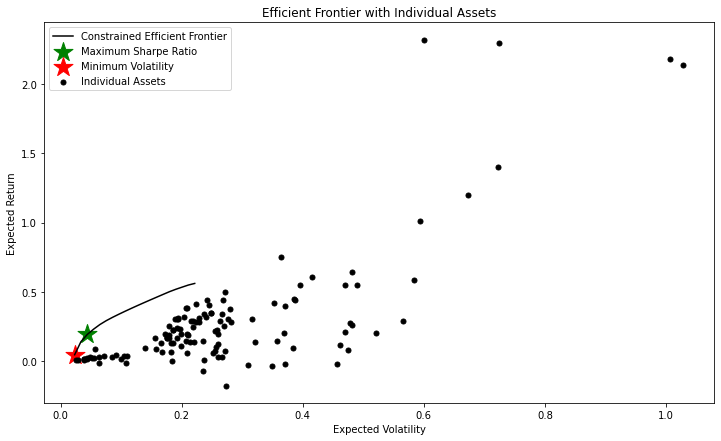

In [34]:
opt.eff_frontier_plot(cov_matrix, exp_returns, results, figsize=(12, 7), save=False, show=True)

Plot monte carlo efficient frontier with random portfolios and save image to charts folder. 

C:\Users\25del\AppData\Roaming\Python\Python38\site-packages\cvxpy\problems\problem.py:1125: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\25del\Anaconda3\envs\pyfinlab\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:252: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


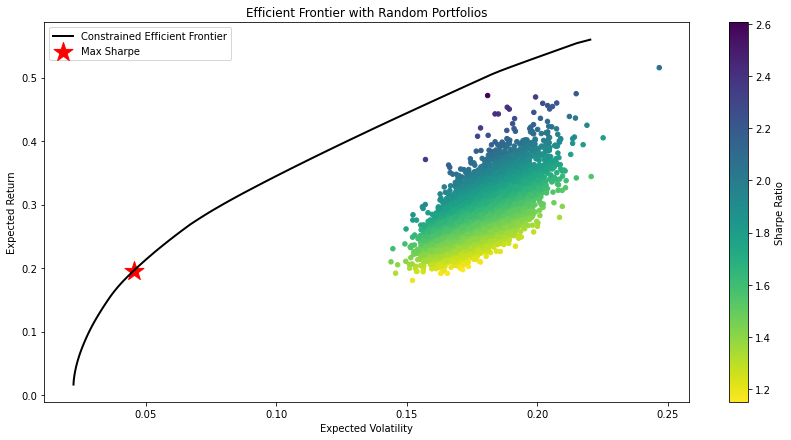

In [35]:
opt.monte_carlo_frontier(
    cov_matrix, exp_returns, figsize=(12, 6), save=False, show=True, restricted=restricted, gamma=gamma)

Top 10 securities by average weighting across all 20 efficient frontier portfolios. 

In [36]:
weightings = optimized_portfolios.iloc[:, 10:]
print('Available Portfolios: {}'.format(list(weightings.columns)))

Available Portfolios: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [37]:
weightings.sum(axis=1).sort_values(ascending=False).head(10) / 20

TICKER
BSV     0.139145
QQQ     0.130290
TIP     0.109670
VGT     0.081200
BNDX    0.073850
IWF     0.049300
VUG     0.047090
ICSH    0.045625
AON     0.035550
PANW    0.035100
dtype: float64

# Backtest Algorithm

The following wrapper functions use the bt Python financial backtesting library. 

In [38]:
benchmark_backtest = bkt.benchmark_backtest(benchmark_ticker, start_date, end_date, api_source)

[*********************100%***********************]  1 of 1 completed


In [39]:
portfolio_backtests = bkt.compile_backtests(weightings, prices)

In [40]:
Results = bkt.run_backtest(portfolio_backtests, benchmark_backtest)

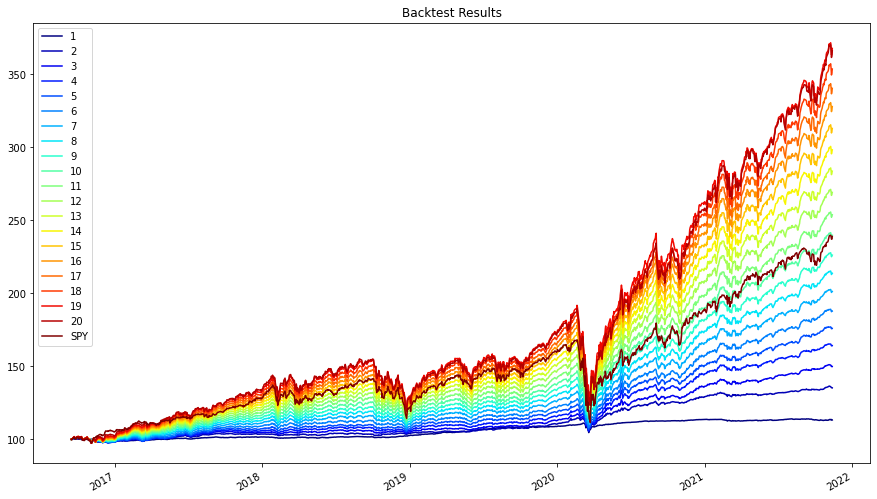

In [41]:
bkt.linechart(Results, save=False, show=True)

Create a dataframe of portfolio values over time. 

In [42]:
backtest_timeseries = bkt.backtest_timeseries(Results, freq='d')
backtest_timeseries.head()

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,SPY
2016-09-16,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,193.769496
2016-09-22,100.306657,100.314618,100.489734,100.667424,100.921233,100.999491,101.062029,101.112850,101.156353,101.201864,...,101.368654,101.467690,101.568955,101.668082,101.766113,101.804103,101.843937,101.894536,101.822731,197.229510
2016-09-23,100.328380,100.329887,100.434624,100.547454,100.737984,100.762788,100.787659,100.801203,100.809412,100.798806,...,100.881613,100.950126,101.017177,101.082539,101.147298,101.146911,101.147209,101.157592,101.099709,196.148778
2016-09-26,100.396681,100.410674,100.509449,100.606590,100.776624,100.773738,100.735015,100.696940,100.657606,100.583018,...,100.580335,100.608081,100.631917,100.653819,100.674775,100.631134,100.590655,100.560367,100.428675,194.559606
2016-09-28,100.423937,100.416375,100.647260,100.802746,101.023338,101.106649,101.130560,101.153998,101.173981,101.165120,...,101.292369,101.367021,101.442107,101.515849,101.588769,101.641884,101.653635,101.656419,101.588887,196.739073


Wrapper function which creates a dataframe of performance statistics using the ffn Python library. 

In [43]:
Results

{'1': <ffn.core.PerformanceStats at 0x27cba139fa0>,
 '2': <ffn.core.PerformanceStats at 0x27cba122430>,
 '3': <ffn.core.PerformanceStats at 0x27cba7c0220>,
 '4': <ffn.core.PerformanceStats at 0x27cba7c0a00>,
 '5': <ffn.core.PerformanceStats at 0x27cba7d74f0>,
 '6': <ffn.core.PerformanceStats at 0x27cba7b72e0>,
 '7': <ffn.core.PerformanceStats at 0x27cba7b7a90>,
 '8': <ffn.core.PerformanceStats at 0x27cb7795580>,
 '9': <ffn.core.PerformanceStats at 0x27cb777e1f0>,
 '10': <ffn.core.PerformanceStats at 0x27cb777e8b0>,
 '11': <ffn.core.PerformanceStats at 0x27cb7658640>,
 '12': <ffn.core.PerformanceStats at 0x27cb7634130>,
 '13': <ffn.core.PerformanceStats at 0x27cb7634be0>,
 '14': <ffn.core.PerformanceStats at 0x27cb76296d0>,
 '15': <ffn.core.PerformanceStats at 0x27cb7b801f0>,
 '16': <ffn.core.PerformanceStats at 0x27cb7b80ca0>,
 '17': <ffn.core.PerformanceStats at 0x27cb7b8f790>,
 '18': <ffn.core.PerformanceStats at 0x27cba688280>,
 '19': <ffn.core.PerformanceStats at 0x27cba688e50>,
 '

In [44]:
perf_data = Results.perf_data()
perf_data

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,SPY
Start,2016-09-15,2016-09-15,2016-09-15,2016-09-15,2016-09-15,2016-09-15,2016-09-15,2016-09-15,2016-09-15,2016-09-15,...,2016-09-15,2016-09-15,2016-09-15,2016-09-15,2016-09-15,2016-09-15,2016-09-15,2016-09-15,2016-09-15,2016-09-15
End,2021-11-12,2021-11-12,2021-11-12,2021-11-12,2021-11-12,2021-11-12,2021-11-12,2021-11-12,2021-11-12,2021-11-12,...,2021-11-12,2021-11-12,2021-11-12,2021-11-12,2021-11-12,2021-11-12,2021-11-12,2021-11-12,2021-11-12,2021-11-12
Risk-free rate,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
,,,,,,,,,,,...,,,,,,,,,,
Total Return,13.25%,35.25%,49.88%,64.21%,75.99%,87.87%,101.27%,113.75%,126.17%,139.76%,...,169.12%,183.68%,198.28%,212.91%,227.91%,240.39%,253.64%,267.73%,266.13%,138.92%
Daily Sharpe,1.23,1.69,1.70,1.70,1.67,1.64,1.63,1.61,1.59,1.56,...,1.52,1.49,1.47,1.45,1.43,1.40,1.37,1.35,1.29,1.02
Daily Sortino,1.74,2.74,2.78,2.76,2.69,2.61,2.56,2.51,2.47,2.41,...,2.33,2.29,2.25,2.21,2.18,2.13,2.09,2.06,1.96,1.53
CAGR,2.44%,6.03%,8.16%,10.09%,11.58%,13.00%,14.52%,15.87%,17.14%,18.48%,...,21.16%,22.40%,23.60%,24.75%,25.89%,26.80%,27.75%,28.72%,28.61%,18.39%
Max Drawdown,-5.88%,-7.96%,-10.13%,-12.17%,-13.84%,-15.49%,-16.81%,-18.04%,-19.18%,-20.62%,...,-23.07%,-24.40%,-25.94%,-27.41%,-28.87%,-30.32%,-31.82%,-33.31%,-34.95%,-33.72%
Calmar Ratio,0.42,0.76,0.81,0.83,0.84,0.84,0.86,0.88,0.89,0.90,...,0.92,0.92,0.91,0.90,0.90,0.88,0.87,0.86,0.82,0.55


# Compute Performance Statistics

Create a dictionary of performance statistics by period lengths in days. 

In [45]:
backtest_statistics = perf.compile_performance_stats(
    backtest_timeseries, risk_model, benchmark_ticker, risk_free_rate)

These are the time periods that were backtested. 

In [46]:
backtested_periods = perf.backtested_periods(backtest_statistics)
print('Periods Backtested: {}'.format(list(backtested_periods.keys())))

Periods Backtested: ['1WK', '1MO', '3MO', '6MO', '1YR', '3YR']


Look up any time period's performance statistics. 

In [47]:
time_period = '3YR' # choose from the list of time periods above. 
backtest_statistics[backtested_periods.get(time_period)]

,vol,beta,cagr,drawdown,capm,jensen_alpha,m2,m2_alpha,sharpe,treynor,sortino,info_ratio,capture_ratio,appraisal_ratio,ulcer
10-30-2018 - 11-12-2021,,,,,,,,,,,,,,,
1,0.0236,0.0269,0.0374,-0.0071,0.0061,0.0313,0.3560,0.1304,1.5825,1.3920,1.4990,-0.0550,0.4424,1.3713,0.6265
2,0.0433,0.0918,0.0938,-0.0091,0.0207,0.0731,0.4876,0.2619,2.1677,1.0214,2.5851,-0.0420,0.9507,1.9219,1.0071
3,0.0581,0.1571,0.1269,-0.0087,0.0354,0.0914,0.4908,0.2651,2.1819,0.8076,2.6344,-0.0348,1.1144,1.9797,0.9615
4,0.0716,0.2137,0.1563,-0.0068,0.0482,0.1081,0.4913,0.2656,2.1841,0.7315,2.6155,-0.0277,1.1407,2.0385,0.9413
5,0.0833,0.2662,0.1772,-0.0060,0.0601,0.1171,0.4783,0.2526,2.1264,0.6656,2.5251,-0.0225,1.1448,2.0211,0.9115
6,0.0947,0.3239,0.1951,-0.0064,0.0731,0.1220,0.4635,0.2378,2.0606,0.6024,2.4180,-0.0178,1.1437,2.0172,0.8560
7,0.1057,0.3853,0.2137,-0.0067,0.0869,0.1268,0.4549,0.2293,2.0226,0.5548,2.3442,-0.0124,1.1391,2.0967,0.8286
8,0.1162,0.4394,0.2303,-0.0070,0.0991,0.1311,0.4459,0.2202,1.9822,0.5240,2.2877,-0.0067,1.1330,2.1481,0.8073
9,0.1266,0.4908,0.2458,-0.0072,0.1108,0.1350,0.4367,0.2111,1.9416,0.5008,2.2331,-0.0005,1.1291,2.1802,0.7877


# Historical Periodic Performance Statistics

Create a dictionary of periodic performance statistics by statistic. 

In [48]:
periodic_stats = perf.compile_periodic_stats(backtest_timeseries, backtest_statistics, backtested_periods)

In [49]:
print('Available Stats: {}'.format(perf.available_keys(backtest_statistics, backtested_periods)))

Available Stats: ['vol', 'beta', 'cagr', 'drawdown', 'capm', 'jensen_alpha', 'm2', 'm2_alpha', 'sharpe', 'treynor', 'sortino', 'info_ratio', 'capture_ratio', 'appraisal_ratio', 'ulcer']


Lookup any available periodic statistic by key. 

In [50]:
key = 'vol'
periodic_stats[key]

,1WK,1MO,3MO,6MO,1YR,3YR
vol,,,,,,
1,0.0046,0.0064,0.0084,0.0104,0.0144,0.0236
2,0.0027,0.0091,0.0127,0.0150,0.0318,0.0433
3,0.0041,0.0098,0.0161,0.0200,0.0430,0.0581
4,0.0052,0.0103,0.0193,0.0247,0.0515,0.0716
5,0.0053,0.0111,0.0221,0.0296,0.0585,0.0833
6,0.0066,0.0121,0.0247,0.0330,0.0663,0.0947
7,0.0078,0.0131,0.0273,0.0360,0.0728,0.1057
8,0.0088,0.0141,0.0300,0.0391,0.0789,0.1162
9,0.0098,0.0152,0.0327,0.0423,0.0852,0.1266


# Excel Report Generation

Generate and save backtest and efficient frontier plots as png files. 

In [51]:
bkt.linechart(Results, figsize=(13, 8), save=True, show=False)
opt.eff_frontier_plot(
    cov_matrix, exp_returns, results, figsize=(13, 8), save=True, show=False)
opt.monte_carlo_frontier(
    cov_matrix, exp_returns, figsize=(12, 7), save=True, show=False, restricted=restricted, gamma=gamma)

C:\Users\25del\AppData\Roaming\Python\Python38\site-packages\cvxpy\problems\problem.py:1125: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\25del\Anaconda3\envs\pyfinlab\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:252: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Generate fully formatted Excel file. 

In [52]:
report.generate_excel_report(
    optimized_portfolios, risk_weightings, results, backtest_timeseries, cash_focus, risk_focus, periodic_stats, title)

# Performance Tracker

In [53]:
holdings_prices = prices[list(weightings.loc[~(weightings==0).all(axis=1)].index)]

In [54]:
print('Top Winners: 1 Day Return')
((holdings_prices.iloc[-1] / holdings_prices.iloc[-2] - 1).sort_values(ascending=False).head(20) * 100).round(2).astype(str) + '%'

Top Winners: 1 Day Return


DVAX     3.29%
MOS      1.58%
PANW     1.44%
VUG      1.26%
IWF       1.2%
VGT       1.2%
HEWJ     1.16%
FANG     1.08%
QQQ      1.05%
WFC      0.73%
AON      0.36%
GLD      0.19%
EMTL     0.17%
BNDX     0.16%
BSV       0.1%
VCSH      0.1%
ICSH     0.04%
ISHG     0.04%
NEAR      0.0%
TIP     -0.02%
dtype: object

In [55]:
print('Top Losers: 1 Month Return')
((holdings_prices.iloc[-1] / holdings_prices.iloc[-22] - 1).sort_values(ascending=True).head(20) * 100).round(2).astype(str) + '%'

Top Losers: 1 Month Return


MOS     -9.66%
CLR     -9.33%
OVV     -9.07%
LPI     -6.85%
AON     -2.44%
ORCL    -1.83%
AR      -1.63%
ISHG    -1.02%
MBB     -0.55%
VCSH    -0.49%
BSV     -0.42%
DVAX    -0.41%
AGG      -0.3%
NEAR     -0.1%
ICSH    -0.03%
EMTL     0.07%
BNDX     0.16%
AIG      0.76%
TIP      1.38%
FANG     1.47%
dtype: object